In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('ggplot')
from PIL import Image, ImageDraw
from tqdm import tqdm

In [3]:
def count_files_in_dirs(dirs):
    total_files = 0
    for dir in dirs:
        if os.path.isdir(dir):
            files = os.listdir(dir)
            total_files += len(files)
    return total_files

In [4]:
class CustomDataset(Dataset):
    def __init__(self, real_dirs, fake_dirs, transform=None):
        self.image_list = []
        self.label_list = []
        self.transform = transform
        
        for directory in real_dirs:
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(0)
                    
        for directory in fake_dirs:
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(1)
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_list[index]).convert('RGB')
        image = image.resize((224, 224))
        label = self.label_list[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
train_sample_metadata = pd.read_json('output/deepfake-detection-challenge/train_sample_videos/metadata.json').T
train_sample_metadata.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [6]:
input_dir = 'output/deepfake-detection-challenge/train_sample_videos/'
real_dirs = []
fake_dirs = []
for i in range(len(train_sample_metadata)):
    fn = train_sample_metadata.index[i]
    label = train_sample_metadata.iloc[i,0]
    fn_dir = input_dir+fn+'/'
    if label=='REAL':
        real_dirs.append(fn_dir)
    else:
        fake_dirs.append(fn_dir)

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = CustomDataset(real_dirs, fake_dirs, transform=train_transforms)
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
len(train_dataset)

10731

In [9]:
test_sample_metadata = pd.read_json('output/deepfake-detection-challenge/dfdc_train_part_0/metadata.json').T
test_sample_metadata.head()

,label,split,original
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4
vpmyeepbep.mp4,REAL,train,NaN
fzvpbrzssi.mp4,REAL,train,NaN
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4


In [10]:
input_dir = 'output/deepfake-detection-challenge/dfdc_train_part_0/'
real_dirs = []
fake_dirs = []
for i in range(len(test_sample_metadata)):
    fn = test_sample_metadata.index[i]
    label = test_sample_metadata.iloc[i,0]
    fn_dir = input_dir+fn+'/'
    if label=='REAL':
        real_dirs.append(fn_dir)
    else:
        fake_dirs.append(fn_dir)

In [11]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = CustomDataset(real_dirs, fake_dirs, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
len(test_dataset)

28931

In [13]:
# model = EfficientNet.from_pretrained('efficientnet-b0')
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Stem
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU(inplace=True)
        # Blocks
        self.blocks = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 32, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 32, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
            ),
        )
        # Head
        self.conv2 = nn.Conv2d(32, 128, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU(inplace=True)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        # Stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        # Blocks
        x = self.blocks(x)
        # Head
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = MyModel()

In [34]:
import torchvision.models as models
model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 1)
for param in model.parameters():
    param.requires_grad = False
for param in model._fc.parameters():
    param.requires_grad = True

Loaded pretrained weights for efficientnet-b0


In [36]:
import timm
model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=2)
num_ftrs = model.classif.in_features
model.classif = nn.Linear(num_ftrs, 1)
for param in model.parameters():
    param.requires_grad = False
for param in model.classif.parameters():
    param.requires_grad = True

In [15]:
def display_model(model):
    # Check number of parameters 
    summary_dict = {}
    num_params = 0
    summary_str = ['='*80]

    for module_name, module in model.named_children():
        summary_count = 0
        for name, param in module.named_parameters():
            if(param.requires_grad):
                summary_count += param.numel()
                num_params += param.numel()
        summary_dict[module_name] = [summary_count]
        summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

    summary_dict['total'] = [num_params]

    # print summary string
    summary_str += ['='*80]
    summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
    print('\n'.join(summary_str))

    # print model structure
    print(model)

In [37]:
display_model(model)
# model.compile(loss="binary_crossentropy", optimizer="nadam",
#               metrics=["accuracy"])
# model.summary()

- conv2d_1a                                :                 0                 
- conv2d_2a                                :                 0                 
- conv2d_2b                                :                 0                 
- maxpool_3a                               :                 0                 
- conv2d_3b                                :                 0                 
- conv2d_4a                                :                 0                 
- maxpool_5a                               :                 0                 
- mixed_5b                                 :                 0                 
- repeat                                   :                 0                 
- mixed_6a                                 :                 0                 
- repeat_1                                 :                 0                 
- mixed_7a                                 :                 0                 
- repeat_2                              

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []
    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:
        # TO DO: read/understand and then uncomment these lines
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        optimizer.zero_grad()
        prediction = model(images)
        loss = criterion(prediction, labels)
        it_train.set_description(f'loss: {loss:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
             precision: precision score of predicted labels
             recall: recall score of predicted labels
             f1: f1 score of predicted labels
    """
    model.eval()
    losses = []
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        with torch.no_grad():
            output = model(images)
            preds = torch.round(torch.sigmoid(output)).type(torch.int)
            loss = criterion(output, labels)
            losses.append(loss.item())
            predicted_labels.extend(preds.cpu().detach().numpy())
            true_labels.extend(labels.cpu().detach().numpy())
            correct += (preds == labels).sum().item()
            total += len(labels)
    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))
    print('Precision: {0:.4f}'.format(precision))
    print('Recall: {0:.4f}'.format(recall))
    print('F1 Score: {0:.4f}'.format(f1))

    return mean_accuracy, test_loss, precision, recall, f1

In [39]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [19]:
train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_interval = 5

# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1):
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    scheduler.step()
    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

    if epoch==0 or (epoch+1)%test_interval==0:
        print('Evaluating Network')

        train_accuracy, _, _, _, _ = test(train_loader, model, criterion)
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss, test_precision, test_recall, test_f1 = test(test_loader, model, criterion)
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        test_precision_list.append(test_precision)
        test_recall_list.append(test_recall)
        test_f1_list.append(test_f1)

        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')


loss: 0.450: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:24<00:00,  2.32it/s]


Loss for Training on epoch 0 is 0.4629218876361847 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [02:07<00:00,  2.63it/s]


Mean Accuracy: 0.8240
Avg loss: 0.4050220965097348
Precision: 0.8275
Recall: 0.9845
F1 Score: 0.8992
Training accuracy on epoch 0 is 0.8239679433417203 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 905/905 [02:16<00:00,  6.65it/s]

Training ...:   5%|███▎                                                              | 1/20 [06:49<2:09:31, 409.03s/it]

Mean Accuracy: 0.7384
Avg loss: 0.5504204837986119
Precision: 0.7402
Recall: 0.9937
F1 Score: 0.8484
Testing accuracy on epoch 0 is 0.7384120839238187 



loss: 0.330: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:04<00:00,  2.69it/s]


Loss for Training on epoch 1 is 0.40399453043937683 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [02:09<00:00,  2.59it/s]


Mean Accuracy: 0.8488
Avg loss: 0.36942041310526075
Precision: 0.8592
Recall: 0.9691
F1 Score: 0.9109
Training accuracy on epoch 1 is 0.8487559407324574 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 905/905 [02:15<00:00,  6.66it/s]

Training ...:  10%|██████▌                                                           | 2/20 [13:19<1:59:29, 398.28s/it]

Mean Accuracy: 0.7466
Avg loss: 0.5398252959656452
Precision: 0.7504
Recall: 0.9830
F1 Score: 0.8511
Testing accuracy on epoch 1 is 0.7466039888009401 



loss: 0.275: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:13<00:00,  2.52it/s]

Training ...:  15%|█████████▉                                                        | 3/20 [15:32<1:18:32, 277.22s/it]

Loss for Training on epoch 2 is 0.3881728947162628 



loss: 0.207: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:15<00:00,  2.48it/s]

Training ...:  20%|█████████████▌                                                      | 4/20 [17:48<58:59, 221.25s/it]

Loss for Training on epoch 3 is 0.3724750280380249 



loss: 0.243: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:09<00:00,  2.60it/s]

Training ...:  25%|█████████████████                                                   | 5/20 [19:57<47:00, 188.03s/it]

Loss for Training on epoch 4 is 0.3685227334499359 



loss: 0.332: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:06<00:00,  2.65it/s]


Loss for Training on epoch 5 is 0.3604419529438019 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [02:01<00:00,  2.76it/s]


Mean Accuracy: 0.8626
Avg loss: 0.3298143706328812
Precision: 0.8735
Recall: 0.9679
F1 Score: 0.9183
Training accuracy on epoch 5 is 0.8626409467896747 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 905/905 [02:14<00:00,  6.74it/s]

Training ...:  30%|████████████████████▍                                               | 6/20 [26:20<59:21, 254.40s/it]

Mean Accuracy: 0.7466
Avg loss: 0.57198507395362
Precision: 0.7474
Recall: 0.9908
F1 Score: 0.8521
Testing accuracy on epoch 5 is 0.7466039888009401 



loss: 0.176: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:04<00:00,  2.69it/s]

Training ...:  35%|███████████████████████▊                                            | 7/20 [28:25<45:56, 212.04s/it]

Loss for Training on epoch 6 is 0.3615305423736572 



loss: 0.535: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:06<00:00,  2.67it/s]

Training ...:  40%|███████████████████████████▏                                        | 8/20 [30:31<36:55, 184.67s/it]

Loss for Training on epoch 7 is 0.3621915578842163 



loss: 0.687: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:22<00:00,  2.36it/s]

Training ...:  45%|██████████████████████████████▌                                     | 9/20 [32:54<31:26, 171.50s/it]

Loss for Training on epoch 8 is 0.36860665678977966 



loss: 0.264: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:17<00:00,  2.44it/s]

Training ...:  50%|█████████████████████████████████▌                                 | 10/20 [35:12<26:51, 161.12s/it]

Loss for Training on epoch 9 is 0.3515443801879883 



loss: 0.253: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:08<00:00,  2.61it/s]


Loss for Training on epoch 10 is 0.3591161072254181 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [02:12<00:00,  2.54it/s]


Mean Accuracy: 0.8631
Avg loss: 0.3274659061183532
Precision: 0.8747
Recall: 0.9668
F1 Score: 0.9185
Training accuracy on epoch 10 is 0.8631068865902526 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 905/905 [02:18<00:00,  6.54it/s]

Training ...:  55%|████████████████████████████████████▊                              | 11/20 [41:52<35:08, 234.24s/it]

Mean Accuracy: 0.7449
Avg loss: 0.5784403610768734
Precision: 0.7456
Recall: 0.9922
F1 Score: 0.8514
Testing accuracy on epoch 10 is 0.7449103038263455 



loss: 0.432: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:16<00:00,  2.46it/s]

Training ...:  60%|████████████████████████████████████████▏                          | 12/20 [44:08<27:15, 204.47s/it]

Loss for Training on epoch 11 is 0.3630400598049164 



loss: 0.273: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:17<00:00,  2.44it/s]

Training ...:  65%|███████████████████████████████████████████▌                       | 13/20 [46:26<21:30, 184.30s/it]

Loss for Training on epoch 12 is 0.36337530612945557 



loss: 0.421: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:19<00:00,  2.41it/s]

Training ...:  70%|██████████████████████████████████████████████▉                    | 14/20 [48:45<17:04, 170.69s/it]

Loss for Training on epoch 13 is 0.3619168996810913 



loss: 0.687: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:18<00:00,  2.43it/s]

Training ...:  75%|██████████████████████████████████████████████████▎                | 15/20 [51:03<13:24, 160.90s/it]

Loss for Training on epoch 14 is 0.357398122549057 



loss: 0.657: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:16<00:00,  2.46it/s]


Loss for Training on epoch 15 is 0.3588257133960724 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [02:20<00:00,  2.40it/s]


Mean Accuracy: 0.8638
Avg loss: 0.3309309379242006
Precision: 0.8778
Recall: 0.9633
F1 Score: 0.9185
Training accuracy on epoch 15 is 0.8637592023110614 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 905/905 [02:17<00:00,  6.57it/s]

Training ...:  80%|█████████████████████████████████████████████████████▌             | 16/20 [57:59<15:49, 237.48s/it]

Mean Accuracy: 0.7452
Avg loss: 0.5778814756676801
Precision: 0.7457
Recall: 0.9925
F1 Score: 0.8516
Testing accuracy on epoch 15 is 0.7451868238221977 



loss: 0.214: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:23<00:00,  2.34it/s]

Training ...:  85%|███████████████████████████████████████████████████████▎         | 17/20 [1:00:22<10:27, 209.26s/it]

Loss for Training on epoch 16 is 0.3593253791332245 



loss: 0.239: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:23<00:00,  2.35it/s]

Training ...:  90%|██████████████████████████████████████████████████████████▌      | 18/20 [1:02:45<06:18, 189.38s/it]

Loss for Training on epoch 17 is 0.35961994528770447 



loss: 0.459: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:17<00:00,  2.45it/s]

Training ...:  95%|█████████████████████████████████████████████████████████████▊   | 19/20 [1:05:03<02:53, 173.75s/it]

Loss for Training on epoch 18 is 0.3602253496646881 



loss: 0.236: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:17<00:00,  2.44it/s]


Loss for Training on epoch 19 is 0.36220085620880127 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [02:20<00:00,  2.40it/s]


Mean Accuracy: 0.8653
Avg loss: 0.3259270083868787
Precision: 0.8781
Recall: 0.9651
F1 Score: 0.9195
Training accuracy on epoch 19 is 0.8653433976330258 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 905/905 [02:13<00:00,  6.76it/s]

Training ...: 100%|█████████████████████████████████████████████████████████████████| 20/20 [1:11:55<00:00, 215.77s/it]

Mean Accuracy: 0.7456
Avg loss: 0.5763605457519628
Precision: 0.7461
Recall: 0.9922
F1 Score: 0.8518
Testing accuracy on epoch 19 is 0.745601603815976 



In [40]:
train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_interval = 5

# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1):
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    scheduler.step()
    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

    if epoch==0 or (epoch+1)%test_interval==0:
        print('Evaluating Network')

        train_accuracy, _, _, _, _ = test(train_loader, model, criterion)
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss, test_precision, test_recall, test_f1 = test(test_loader, model, criterion)
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        test_precision_list.append(test_precision)
        test_recall_list.append(test_recall)
        test_f1_list.append(test_f1)

        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')


loss: 0.371: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:35<00:00,  2.16it/s]


Loss for Training on epoch 0 is 0.46722671389579773 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [02:28<00:00,  2.26it/s]


Mean Accuracy: 0.8258
Avg loss: 0.42237628038440433
Precision: 0.8315
Recall: 0.9801
F1 Score: 0.8997
Training accuracy on epoch 0 is 0.8258317025440313 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 905/905 [03:28<00:00,  4.34it/s]

Training ...:  20%|█████████████▊                                                       | 1/5 [08:33<34:14, 513.69s/it]

Mean Accuracy: 0.7337
Avg loss: 0.5810318557596997
Precision: 0.7401
Recall: 0.9841
F1 Score: 0.8448
Testing accuracy on epoch 0 is 0.7337112439943313 



loss: 0.275: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:43<00:00,  2.05it/s]

Training ...:  40%|███████████████████████████▌                                         | 2/5 [11:17<15:23, 307.92s/it]

Loss for Training on epoch 1 is 0.40873029828071594 



loss: 0.369: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:47<00:00,  2.00it/s]

Training ...:  60%|█████████████████████████████████████████▍                           | 3/5 [14:05<08:07, 243.91s/it]

Loss for Training on epoch 2 is 0.38085561990737915 



loss: 0.146: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:48<00:00,  1.99it/s]

Training ...:  80%|███████████████████████████████████████████████████████▏             | 4/5 [16:54<03:34, 214.33s/it]

Loss for Training on epoch 3 is 0.36009910702705383 



loss: 0.192: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:48<00:00,  1.99it/s]


Loss for Training on epoch 4 is 0.36002030968666077 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [02:43<00:00,  2.05it/s]


Mean Accuracy: 0.8528
Avg loss: 0.34889374438318466
Precision: 0.8566
Recall: 0.9793
F1 Score: 0.9138
Training accuracy on epoch 4 is 0.8527630230174261 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 905/905 [03:32<00:00,  4.25it/s]

Training ...: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [26:00<00:00, 312.08s/it]

Mean Accuracy: 0.7392
Avg loss: 0.6284897455585431
Precision: 0.7456
Recall: 0.9804
F1 Score: 0.8470
Testing accuracy on epoch 4 is 0.7392070789118939 



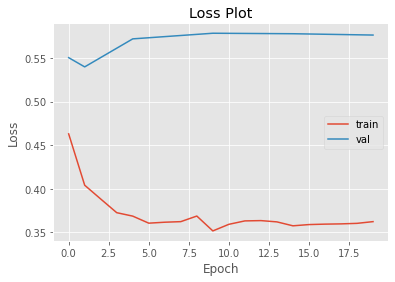

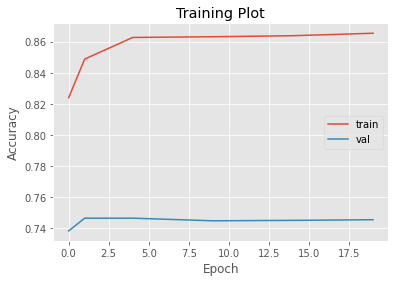

In [20]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Training Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_F1(val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("F-1 Plot")
    plt.ylabel("F-1 Score")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
plot_losses(train_losses, test_losses, test_interval, num_epochs)
plot_accuracy(train_accuracy_list, test_accuracy_list, test_interval, num_epochs)
plot_F1(test_f1_list, test_interval, num_epochs)

In [19]:
import random
def eval_example(model, dirs):
    model.eval()
    image_path = random.choice(dirs)+'0.jpg'
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.show()
    image = image.resize((224, 224))
    image = train_transforms(image).unsqueeze(0).to(device)
    output = model(image)
    pred = torch.sigmoid(output).item()
    print(output.item())
    if pred>0.5:
        print('Prediction: FAKE')
    else:
        print('Prediction: REAL')

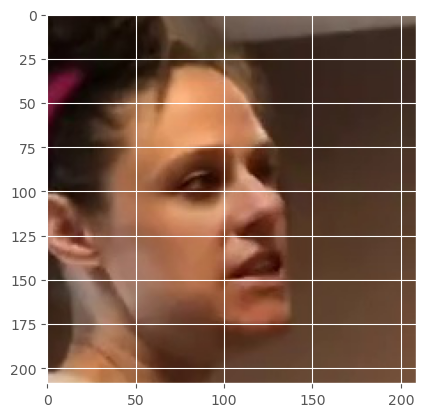

3.02608060836792
Prediction: FAKE


In [26]:
f = eval_example(model, fake_dirs)

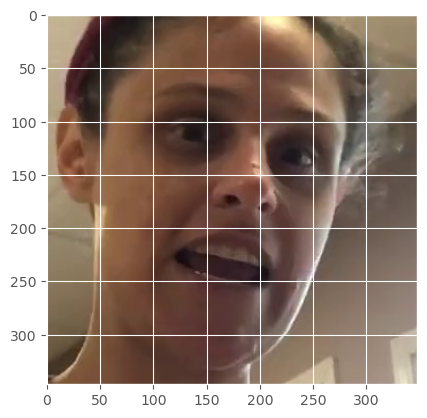

1.1725478172302246
Prediction: FAKE


In [27]:
r = eval_example(model, real_dirs)